# Wind Power Forecast Model

In [1]:
import datetime as dt
import sys
sys.path.insert(0,'../../../..')
from typing import List
import numpy as np
import matplotlib.pyplot as plt
from rivapy.tools.datetime_grid import DateTimeGrid

from rivapy.models.residual_demand_fwd_model import WindPowerForecastModel, _inv_logit

%load_ext autoreload
%autoreload 2
%matplotlib inline

C:\Users\doeltz\development\RiVaPy\docs\source\notebooks\models\../../../..\rivapy\__init__.py:11: UserWarning: The pyvacon module is not available. You may not use all functionality without this module. Consider installing pyvacon.
  warnings.warn('The pyvacon module is not available. You may not use all functionality without this module. Consider installing pyvacon.')


## Forecast Simulations

In [31]:
model = WindPowerForecastModel('Onshore', speed_of_mean_reversion=0.1, volatility=1.5)

In [32]:
timegrid = np.linspace(0.0,1.0, 365)
rnd = np.random.normal(size=model.rnd_shape(10_000, timegrid.shape[0]))
results = model.simulate(timegrid, rnd, expiries=[1.0], initial_forecasts=[0.8], startvalue=0.0)

In [33]:
onshore_wind = results.get('Onshore_FWD0',n_points_approx_call=200)

C:\Users\doeltz\development\RiVaPy\docs\source\notebooks\models\../../../..\rivapy\models\ornstein_uhlenbeck.py:114: RuntimeWarning: invalid value encountered in divide
  d = (g - K) / sigma_bar


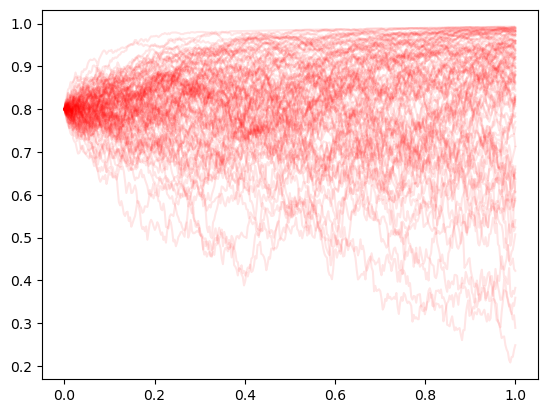

In [34]:
for i in range(100):
    plt.plot(timegrid, onshore_wind[:,i],'-r', alpha=0.1)

In [36]:
print(results._ou_additive_forward_corrections)
onshore_wind[-1,:].mean()

[2.07358792]


nan

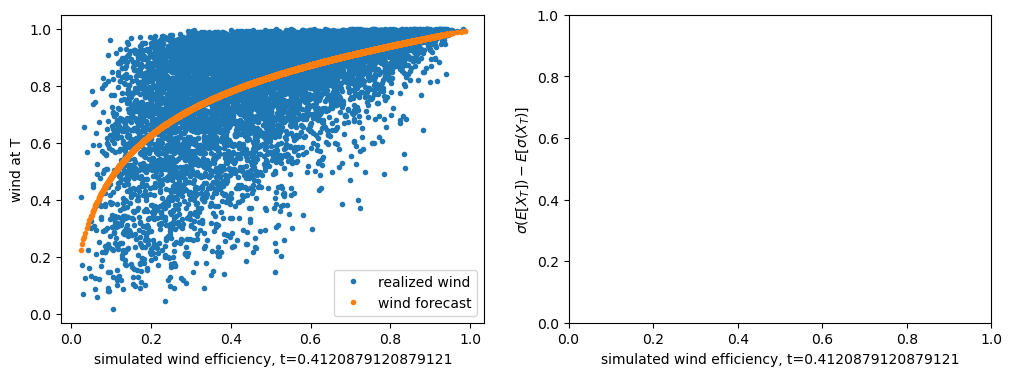

In [29]:
timepoint = 150
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
x = _inv_logit(results._paths[timepoint,:])
plt.plot(x,_inv_logit(results._paths[-1,:]+results._ou_additive_forward_corrections[0]),'.', label='realized wind')
inv_logit_from_expectation =  _inv_logit(model.ou.compute_expected_value(results._paths[timepoint,:], 
                                                       T=timegrid[-1]-timegrid[timepoint])) + results._ou_additive_forward_corrections
plt.plot(x, onshore_wind[timepoint,:],'.', label='wind forecast')
#plt.plot(x,inv_logit_from_expectation,'.', label='inverse')
plt.xlabel('simulated wind efficiency, t='+str(timegrid[timepoint]))
plt.ylabel('wind at T')
plt.legend();
plt.subplot(1,2,2)
#plt.plot(x, inv_logit_from_expectation-onshore_wind[timepoint,:],'.')
plt.xlabel('simulated wind efficiency, t='+str(timegrid[timepoint]))
plt.ylabel('$\sigma(E[X_T])-E[\sigma(X_T)]$');

In [30]:
results._ou_additive_forward_corrections

array([2.08225941])

In [ ]:
from rivapy.models.residual_demand_fwd_model import _logit, _inv_logit
    
left = -7.0
right = 10.0
x = np.linspace(start=left,stop=right,num=1000)
y = _inv_logit(x)
plt.plot(x,y)

strikes = np.linspace(start=-5, stop=5, num=10)
#np.interp(x, strikes, _inv_logit(strikes))
def compute_call_weights(strikes,f): #we assume that f(strikes[0])=0 but nevertheless f.shape[0] == strikes.shape[0], i.e. zero is included
    weights = np.zeros((strikes.shape[0]+1))
    h = strikes[1]-strikes[0]
    butterfly_weights = [1, -2,  1]/h
    for s in range(1,strikes.shape[0]):
        weights[s-1] += f[s]*butterfly_weights[0]
        weights[s] += f[s]*butterfly_weights[1]
        weights[s+1] += f[s]*butterfly_weights[2]
    weights[-2] -= 0.5* butterfly_weights[1]*f[s]
    return weights[:-1]

def eval_call_functions(strikes, weights, x):
    #weights = compute_call_weights(strikes, _inv_logit(strikes))
    approx = np.copy(weights[0]*np.maximum(x-strikes[0],0.0))
    for i in range(1,weights.shape[0]):
        approx += weights[i]*np.maximum(x-strikes[i],0.0)
    return approx
weights = compute_call_weights(strikes, _inv_logit(strikes))
plt.plot(x,eval_call_functions(strikes, weights, x), '-')
plt.figure()
plt.plot(eval_call_functions(strikes, weights, x)-_inv_logit(x))